## Group Project Title: Anlysis of Blue Voters in Red States

Group Members: Joseph Chang, Grant Cai, Chen Guo

In [1]:
from pyspark.sql import SparkSession
import pyspark as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import pandas as pd
from pyspark.sql.types import IntegerType,BooleanType,DateType 
from pyspark.sql.functions import sum, col, desc

In [2]:
np.set_printoptions(precision = 3, linewidth = 100)

### Load the datasets into one humongous dataframe with an indicator column called "State" so that no information is lost in the process

In [2]:
states = ['VM2Uniform--FL--2021-05-19'
,'VM2Uniform--GA--2021-04-16'
,'VM2Uniform--MS--2021-03-23'
,'VM2Uniform--SC--2021-04-16'
,'VM2Uniform--TN--2021-03-29'
,'VM2Uniform--TX--2021-06-12']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform/'
print('VM2Uniform--AL--2021-02-04')
df = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--AL--2021-02-04']))
df = df.withColumn('State', f.lit('AL'))
print(df.count())

for one_state in states:
    print("%s: " % (one_state), end="")
    # read dataframe for one_state
    tmp = spark.read.parquet("/".join([gcs_path, one_state]))
    tmp = tmp.withColumn('State', f.lit(one_state[12:14]))
    df = df.union(tmp)

    print(tmp.count())

VM2Uniform--AL--2021-02-04


3458534
VM2Uniform--FL--2021-05-19: 

14168189
VM2Uniform--GA--2021-04-16: 

7105478
VM2Uniform--MS--2021-03-23: 

1983032
VM2Uniform--SC--2021-04-16: 

3318276
VM2Uniform--TN--2021-03-29: 

4076696
VM2Uniform--TX--2021-06-12: 

15983112


In [3]:
print(df.count())

50093317


In [5]:
#df.cache()

In [27]:
#df.printSchema()

### Data Cleaning by selecting the columns we want and do some stupid but necessary manual work

In [4]:
new_df = df.select('State','County','Voters_Active', 'Voters_Gender', 'Voters_Age', \
                   "EthnicGroups_EthnicGroup1Desc", "Parties_Description", \
                   "CommercialData_EstimatedHHIncome",  "CommercialData_Education", \
                   'ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D').dropna()

## Because you guys want to use "job" as a predictor, which is quite difficult, since there are too many types of jobs as appropriate for our naive model you get what i'm saying?

In [6]:
job_df = df.select('CommercialData_Occupation')
job_df.select('CommercialData_Occupation').distinct().show()
#Too many types of jobs. Therefore we probably should exclude this column

+-------------------------+
|CommercialData_Occupation|
+-------------------------+
|      Engineer-Electrical|
|     Manufacturing-Mil...|
|     Skilled Trades-Te...|
|        Management-Market|
|     Office Assistant-...|
|     Manufacturing-Fou...|
|     Skilled Trades-Cl...|
|          Creative-Editor|
|     Financial-Bookkeeper|
|     Manufacturing-Fab...|
|     Skilled Trades-Fo...|
|     Manufacturing-Ski...|
|     Education-Instructor|
|        Computer-Operator|
|     Civil Servant-Mai...|
|     Management-Artist...|
|     Skilled Trades-Li...|
|     Education-Princip...|
|     Maintenance-Repai...|
|        Services/Creative|
+-------------------------+
only showing top 20 rows



## How you guys defined VoteRepub which is equivalent to County_Swing but better since it is bloody boolean so we can convert it into the labels column anyway a trivial point but I have to mention.

In [5]:
new_df = new_df.withColumn("ElectionReturns_G16_Cnty_Vote_Trump_R",new_df.ElectionReturns_G16_Cnty_Vote_Trump_R.cast(IntegerType()))

new_df= new_df.withColumn("ElectionReturns_G16_Cnty_Vote_Clinton_D",new_df.ElectionReturns_G16_Cnty_Vote_Clinton_D.cast(IntegerType()))

new_df = new_df.withColumn('VoteRepub', new_df['ElectionReturns_G16_Cnty_Vote_Trump_R'] > new_df['ElectionReturns_G16_Cnty_Vote_Clinton_D'])


new_df.printSchema()

#new_df = new_df.withColumn("County_Swing", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")) #The column County_Swing has some problems.

root
 |-- State: string (nullable = false)
 |-- County: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- ElectionReturns_G16_Cnty_Vote_Trump_R: integer (nullable = true)
 |-- ElectionReturns_G16_Cnty_Vote_Clinton_D: integer (nullable = true)
 |-- VoteRepub: boolean (nullable = true)



In [6]:
#Convert Age to double type
new_df = new_df.withColumn('Age', new_df.Voters_Age.astype('double'))

#Index Gender 1 = male 0 = female
new_df = new_df.withColumn('Gender', (new_df.Voters_Gender == 'M').astype('double'))

#Index VoteRepub 1 = Republican 0 = Democratic
new_df = new_df.withColumn('VoteRepub', (new_df.VoteRepub).astype('int'))

#Has Bachlor Degree/Above = 1 No Bachlor Degree = 0
new_df = new_df.withColumn('HasDegree', (new_df.CommercialData_Education.contains('Degree')).astype('double'))

#Manual One-Hot Encoding Income. Threshold based on empirical data (see U.S. Census Bureau 2016 Report, etc.)
#Manual One-Hot Encoding is probably necessary because we'll run an SQL command over it. You can't have some weird vector column that does not work with SQL commands (e.g., you can't take the average, which is what I'm going to do)
new_df = new_df.withColumn('Poor', new_df.CommercialData_EstimatedHHIncome.isin(\
        '$1000-14999', '$15000-24999', '$25000-34999').astype('double'))
new_df = new_df.withColumn('Wealthy', new_df.CommercialData_EstimatedHHIncome.isin(\
        '$125000-149999', '$150000-174999', '$175000-199999', '$2000000-249999', '$250000+').astype('double'))

#Manual One-Hot Encoding Ethnicity
new_df = new_df.withColumn('European', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Euro')).astype('double'))
new_df = new_df.withColumn('African', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Africa')).astype('double'))
new_df = new_df.withColumn('Asian', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Asia')).astype('double'))
new_df = new_df.withColumn('Latino', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Hisp')).astype('double'))
new_df = new_df.withColumn('Other', (new_df.EthnicGroups_EthnicGroup1Desc.contains('Other')).astype('double'))
#new_df.show()

In [7]:
new_df = new_df.select('State', 'County', 'Age', 'Gender', 'HasDegree', 'European', 'African', 'Asian', \
                       'Latino', 'Other', 'Poor', 'Wealthy', 'VoteRepub')
#new_df.show()

In [8]:
new_df.createOrReplaceTempView('new_df')

23/03/19 09:11:18 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
#Run an SQL to get the means of basically everything. These averages are essentially percentage. For instance, if a county has a "Gender" value of 0.4 that means 40% of the population in our dataset from that county is male, and 60% is female. This point applies to every column.
#We need to group by State AND County because there are counties in different states that share the same bloody name.
#For long commands like these SQL is significantly easier to write.

new_df = spark.sql('SELECT State, County, \
                    ROUND(AVG(Age),4) as Age, \
                    ROUND(AVG(Gender),4) as Gender, \
                    ROUND(AVG(HasDegree),4) as HasDegree, \
                    COUNT(*) as Population, \
                    ROUND(AVG(European), 4) as European, \
                    ROUND(AVG(African), 4) as African, \
                    ROUND(AVG(Asian), 4) as Asian, \
                    ROUND(AVG(Latino), 4) as Latino, \
                    ROUND(AVG(Other), 4) as Other, \
                    ROUND(AVG(Poor), 4) as Poor, \
                    ROUND(AVG(Wealthy), 4) as Wealthy, \
                    ROUND(AVG(VoteRepub),4) as VoteRepub \
                    FROM new_df GROUP BY State, County')

In [3]:
new_df.cache()

DataFrame[State: string, County: string, Age: double, Gender: double, HasDegree: double, Population: bigint, European: double, African: double, Asian: double, Latino: double, Other: double, Poor: double, Wealthy: double, VoteRepub: double]

In [12]:
#new_df.write.parquet("gs://pstat135-bw/notebooks/jupyter/data/cleaned.parquet")

In [2]:
new_df = spark.read.parquet("gs://pstat135-bw/notebooks/jupyter/data/cleaned.parquet")

In [4]:
new_df.show(20)

+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+
|State|    County|    Age|Gender|HasDegree|Population|European|African| Asian|Latino| Other|  Poor|Wealthy|VoteRepub|
+-----+----------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+
|   SC|  BERKELEY|52.8474|0.4572|   0.3595|     82551|  0.6742| 0.2649|0.0073|0.0407|0.0129|0.1274| 0.1718|      1.0|
|   TN|    SUMNER|53.5464| 0.461|   0.3941|     71719|   0.917| 0.0408|0.0097|0.0239|0.0085|0.0984|  0.231|      1.0|
|   TN|    WILSON|53.3388|0.4656|   0.4142|     57116|  0.9268| 0.0262|0.0108|0.0234|0.0127|0.0897| 0.2551|      1.0|
|   TX|  COLORADO|56.9322|0.4815|   0.3487|      8203|  0.7316| 0.0741|0.0063|0.1675|0.0205|0.1707| 0.1665|      1.0|
|   AL|   PICKENS| 54.824|0.4412|   0.2578|      8212|  0.6027| 0.3868| 0.004|0.0043|0.0023| 0.263| 0.0554|      1.0|
|   FL|   WAKULLA|54.0865|0.4701|   0.3337|     14016|  

In [4]:
new_df.cache()

23/03/20 10:20:04 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


DataFrame[State: string, County: string, Age: double, Gender: double, HasDegree: double, Population: bigint, European: double, African: double, Asian: double, Latino: double, Other: double, Poor: double, Wealthy: double, VoteRepub: double]

### Write the formula

In [3]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="VoteRepub ~ Age + Gender + HasDegree + Population + European + African + Asian + Latino + Poor + Wealthy" )

### Transform the Dataframe into machine-readable format

In [46]:
fittedFormula = supervised.fit(new_df)  # fit the transformer
preparedDF = fittedFormula.transform(new_df)  # transform
preparedDF.show(5, False)

+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+-------------------------------------------------------------------------+-----+
|State|County  |Age    |Gender|HasDegree|Population|European|African|Asian |Latino|Other |Poor  |Wealthy|VoteRepub|features                                                                 |label|
+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+-------------------------------------------------------------------------+-----+
|SC   |BERKELEY|52.8474|0.4572|0.3595   |82551     |0.6742  |0.2649 |0.0073|0.0407|0.0129|0.1274|0.1718 |1.0      |[52.8474,0.4572,0.3595,82551.0,0.6742,0.2649,0.0073,0.0407,0.1274,0.1718]|1.0  |
|TN   |SUMNER  |53.5464|0.461 |0.3941   |71719     |0.917   |0.0408 |0.0097|0.0239|0.0085|0.0984|0.231  |1.0      |[53.5464,0.461,0.3941,71719.0,0.917,0.0408,0.0097,0.0239,0.0984,0.231]   |1.0  |
|TN   |WILSON  |53.3

In [7]:
preparedDF.count()

770

### Split the dataframe into training & testing sets; 80/20 is a better ratio than 70/30

In [5]:
train, test = preparedDF.randomSplit([0.8, 0.2], seed = 1729)

In [6]:
test.show(7)

+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+
|State|  County|    Age|Gender|HasDegree|Population|European|African| Asian|Latino| Other|  Poor|Wealthy|VoteRepub|            features|label|
+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+
|   AL|CHEROKEE|56.5188|0.4786|   0.2807|     11060|  0.9426|  0.041|0.0043|0.0081| 0.004|0.2168| 0.0616|      1.0|[56.5188,0.4786,0...|  1.0|
|   AL|MARSHALL|55.3916|0.4718|   0.3399|     35673|  0.9431| 0.0136|0.0061|0.0302| 0.007|0.1887| 0.1133|      1.0|[55.3916,0.4718,0...|  1.0|
|   AL|  MOBILE|53.7073| 0.442|   0.3594|    162360|   0.619| 0.3405|0.0122|0.0175|0.0109|0.2125| 0.1186|      1.0|[53.7073,0.442,0....|  1.0|
|   AL|   PERRY|53.7697| 0.403|    0.223|      3829|  0.2839| 0.7096|0.0013|0.0024|0.0029|0.4586| 0.0457|      0.0|[53.7697,0.403,0....|  0.0|

### Import Evaluators

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator()
bin_evaluator = BinaryClassificationEvaluator()

### Import Cross Validator and Parameter Grid Builder

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
cv = CrossValidator(numFolds = 5, evaluator = bin_evaluator)

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

logistic = LogisticRegression()
logisticGrid = ParamGridBuilder() \
               .addGrid(logistic.regParam, [0.01, 0.1, 1.0, 10.0]) \
               .addGrid(logistic.elasticNetParam, [0.0, 0.5, 1.0]) \
               .build()
fittedLR = cv.setEstimator(logistic).setEstimatorParamMaps(logisticGrid).fit(train)

23/03/21 00:23:40 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 00:23:40 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


### Save and Re-Load Fitted Model to Save Time

In [36]:
#fittedLR.save("gs://pstat135-bw/notebooks/jupyter/models/fittedLR")

In [16]:
fittedLR2 = CrossValidatorModel.load("gs://pstat135-bw/notebooks/jupyter/models/fittedLR")

### Use our Logistic Regression Model to Predict the Testing data

In [17]:
LR_prediction = fittedLR2.transform(test)
#.select("label", "prediction",'probability')

### Decision Tree

In [59]:
from pyspark.ml.classification import DecisionTreeClassifier

tree = DecisionTreeClassifier()
treeGrid = ParamGridBuilder() \
               .addGrid(tree.maxDepth, [2, 5, 10, 20]) \
               .addGrid(tree.maxBins, [2, 8, 32, 128]) \
               .build()
fittedTree = cv.setEstimator(tree).setEstimatorParamMaps(treeGrid).fit(train)

In [12]:
#fittedTree.save("gs://pstat135-bw/notebooks/jupyter/models/fittedTree")

In [20]:
fittedTree2 = CrossValidatorModel.load("gs://pstat135-bw/notebooks/jupyter/models/fittedTree")

In [21]:
Tree_prediction = fittedTree2.transform(test)
#.select("label", "prediction",'probability')


### Random Forest

In [36]:
from pyspark.ml.classification import RandomForestClassifier

RF = RandomForestClassifier()
RFGrid = ParamGridBuilder() \
               .addGrid(RF.maxDepth, [2, 4, 7, 10]) \
               .addGrid(RF.maxBins, [2, 4, 8, 16]) \
               .addGrid(RF.numTrees, [2, 4, 7, 10]) \
               .build()
fittedRF = cv.setEstimator(RF).setEstimatorParamMaps(RFGrid).fit(train)

In [37]:
fittedRF.save("gs://pstat135-bw/notebooks/jupyter/models/fittedRF2")

In [38]:
fittedRF2 = CrossValidatorModel.load("gs://pstat135-bw/notebooks/jupyter/models/fittedRF2")

In [39]:
RF_prediction = fittedRF2.transform(test)

### Gradient Boosted Tree

#### GBT Algorithm is so fucking slow what the fuck pyspark?

In [ ]:
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier()
GBTGrid = ParamGridBuilder() \
               .addGrid(GBT.maxDepth, [2, 4, 7, 10]) \
               .addGrid(GBT.maxBins, [2, 4, 8, 16]) \
               .addGrid(GBT.stepSize, [0.1, 0.5, 0.9]) \
               .build()
        
fittedGBT = cv.setEstimator(GBT).setEstimatorParamMaps(GBTGrid).fit(train)

In [35]:
#fittedGBT.save("gs://pstat135-bw/notebooks/jupyter/models/fittedGBT2")

In [32]:
fittedGBT2 = CrossValidatorModel.load("gs://pstat135-bw/notebooks/jupyter/models/fittedGBT2")

In [33]:
GBT_prediction = fittedGBT2.transform(test)

### Compare Models?

In [40]:
model_name = ['Logistic Regression', 'Single Decision Tree', 'Random Forest', 'Gradient-Boosted Tree']
model_list = [LR_prediction, Tree_prediction, RF_prediction, GBT_prediction]
accuracy = []
AUC_ROC = []
for model in model_list:
    accuracy.append(multi_evaluator.evaluate(model, {multi_evaluator.metricName:"accuracy"}))
    AUC_ROC.append(bin_evaluator.evaluate(model, {bin_evaluator.metricName:"areaUnderROC"}))
comparison_chart = pd.DataFrame({'Model Name': model_name, \
                                 'Accuracy': accuracy, \
                                 'Area Under ROC': AUC_ROC})
comparison_chart

,Model Name,Accuracy,Area Under ROC
0,Logistic Regression,0.963190,0.998199
1,Single Decision Tree,0.957055,0.988806
2,Random Forest,0.963190,0.992409
3,Gradient-Boosted Tree,0.957055,0.992023


### Therefore, (insert model) is our best model

In [50]:
best_model = fittedLR.bestModel

### Evaluate Model on the training set

In [56]:
print(summary.accuracy, summary.areaUnderROC, summary.weightedPrecision, summary.weightedRecall)

0.9802306425041186 0.9963307240704501 0.9801850484350413 0.9802306425041186


### Read Coefficients of Our Best LR Model

In [51]:
summary = best_model.summary

In [55]:
coeff = fittedLR.bestModel.coefficients
coeff

DenseVector([-0.0085, -4.2075, -9.8005, -0.0, 13.579, -7.9034, -0.7523, -0.6358, 0.0, 0.0])

## They correspond to Age, Gender, HasDegree, Population, European, African, Asian, Latino, Poor, Wealthy respectively

In [58]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [59]:
featureCols = featureCols.set_index('idx')
featureCols

,name
idx,
0,Age
1,Gender
2,HasDegree
3,Population
4,European
5,African
6,Asian
7,Latino
8,Poor


In [62]:
coefsArray = np.array(coeff) 
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  
coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True) 
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF

,coefs,name
2,-9.800458,HasDegree
5,-7.903380,African
1,-4.207501,Gender
6,-0.752325,Asian
7,-0.635758,Latino
0,-0.008550,Age
3,-0.000002,Population
8,0.000000,Poor
9,0.000000,Wealthy
4,13.579009,European


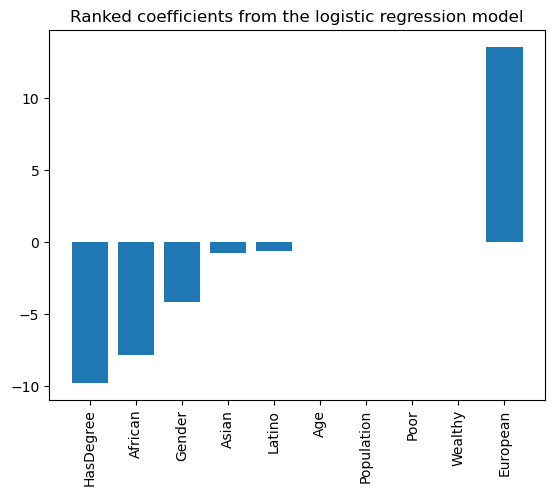

In [63]:
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

### Therefore, a county leans more Democratic is its population is younger, more educated, more diverse, and has more women. Population is not a significant factor.

### Surprisingly, the proportion of poor people and the proportion of rich people in a county does not have much significance in terms of the county's overall political leanings.

### That does not mean wealth itself is not a factor, though, since we did not impute the wealth. Speaking of which, it is quite difficult to impute wealth for each group of people because wealth distribution does not fit the "easier distrutions" well. It is heavily skewed to the wealthy side and has a cutoff on the poor side (at the legal minimum wage). 

### In terms of significance, we can roughly estimate that racial composition (especially people of European and African descent), education, and gender are quite important. We can't directly compare the values, though, as these predictors are not normalised.

### Turn predictions into a Pandas Dataframe to better visualise???

In [49]:
LR_pd = LR_prediction.toPandas()
#pd.set_option('display.max_rows', None)
LR_pd.drop(columns = ['features', 'rawPrediction'])

,State,County,Age,Gender,HasDegree,Population,European,African,Asian,Latino,Other,Poor,Wealthy,VoteRepub,label,probability,prediction
0,AL,CHEROKEE,56.5188,0.4786,0.2807,11060,0.9426,0.0410,0.0043,0.0081,0.0040,0.2168,0.0616,1.0,1.0,"[0.00014773119486210845, 0.9998522688051379]",1.0
1,AL,MARSHALL,55.3916,0.4718,0.3399,35673,0.9431,0.0136,0.0061,0.0302,0.0070,0.1887,0.1133,1.0,1.0,"[0.000217740072760077, 0.9997822599272399]",1.0
2,AL,MOBILE,53.7073,0.4420,0.3594,162360,0.6190,0.3405,0.0122,0.0175,0.0109,0.2125,0.1186,1.0,1.0,"[0.2456862714525224, 0.7543137285474776]",1.0
3,AL,PERRY,53.7697,0.4030,0.2230,3829,0.2839,0.7096,0.0013,0.0024,0.0029,0.4586,0.0457,0.0,0.0,"[0.9887925813939313, 0.011207418606068664]",0.0
4,AL,PICKENS,54.8240,0.4412,0.2578,8212,0.6027,0.3868,0.0040,0.0043,0.0023,0.2630,0.0554,1.0,1.0,"[0.13277495667229858, 0.8672250433277015]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,TN,JACKSON,56.4338,0.4871,0.2576,4666,0.9790,0.0017,0.0032,0.0111,0.0049,0.2538,0.0617,1.0,1.0,"[5.3855984839079955e-05, 0.9999461440151609]",1.0
159,TX,GRAY,55.1597,0.4764,0.2806,7259,0.8373,0.0109,0.0059,0.1400,0.0059,0.2181,0.0906,1.0,1.0,"[0.0005138205565688822, 0.9994861794434311]",1.0
160,TX,HOPKINS,55.2238,0.4711,0.3125,13627,0.8689,0.0460,0.0083,0.0723,0.0045,0.1825,0.1299,1.0,1.0,"[0.0005746366598941313, 0.9994253633401059]",1.0
161,TX,CRANE,50.6836,0.4908,0.3118,1520,0.4316,0.0053,0.0053,0.5546,0.0033,0.1349,0.1336,1.0,1.0,"[0.17803222226849189, 0.8219677777315081]",1.0


### Examine counties where our prediction confidence is relatively weak which implies that election results from these counties should be relatively close

In [48]:
LR_pd['Confidence'] = LR_pd.probability.apply(lambda x: x[0])
LR_pd.where(LR_pd['Confidence'] > 0.2).where(LR_pd['Confidence'] < 0.8).dropna()[['State', 'County', 'VoteRepub', 'prediction', 'Confidence']]

,State,County,VoteRepub,prediction,Confidence
2,AL,MOBILE,1.0,1.0,0.245686
13,GA,CLAY,0.0,0.0,0.543208
48,TX,DEAF SMITH,1.0,1.0,0.205266
60,AL,MARENGO,0.0,0.0,0.736294
62,FL,PALM BEACH,0.0,1.0,0.392901
67,MS,CHICKASAW,1.0,1.0,0.368201
73,SC,MARLBORO,0.0,0.0,0.717418
83,TX,CULBERSON,0.0,1.0,0.321592
88,TX,LA SALLE,0.0,0.0,0.717889
95,AL,PIKE,1.0,1.0,0.214262


### We can do a reality check to see if that's true?

### Let's see where we got it wrong

In [65]:
LR_pd.where(LR_pd['label'] != LR_pd['prediction']).dropna()

,State,County,Age,Gender,HasDegree,Population,European,African,Asian,Latino,Other,Poor,Wealthy,VoteRepub,features,label,rawPrediction,probability,prediction
62,FL,PALM BEACH,56.3107,0.4559,0.4857,506056.0,0.6167,0.1474,0.0218,0.1780,0.0360,0.1166,0.2643,0.0,"[56.3107, 0.4559, 0.4857, 506056.0, 0.6167, 0....",0.0,"[-0.4351328597550521, 0.4351328597550521]","[0.3929013204569236, 0.6070986795430764]",1.0
83,TX,CULBERSON,53.9488,0.5013,0.1280,742.0,0.2520,0.0000,0.0081,0.7358,0.0040,0.1833,0.0809,0.0,"[53.9488, 0.5013, 0.128, 742.0, 0.252, 0.0, 0....",0.0,"[-0.7464634480970913, 0.7464634480970913]","[0.32159238559271663, 0.6784076144072834]",1.0
94,TX,TRAVIS,48.8984,0.4763,0.5837,401690.0,0.6868,0.0339,0.0551,0.1969,0.0273,0.0783,0.3317,0.0,"[48.8984, 0.4763, 0.5837, 401690.0, 0.6868, 0....",0.0,"[-1.4929582247326867, 1.4929582247326867]","[0.18347812918303236, 0.8165218708169677]",1.0
97,GA,CLARKE,51.2531,0.4330,0.5094,31323.0,0.6356,0.2815,0.0175,0.0513,0.0141,0.2228,0.1783,0.0,"[51.2531, 0.433, 0.5094, 31323.0, 0.6356, 0.28...",0.0,"[-0.6641352239340657, 0.6641352239340657]","[0.33981130353837374, 0.6601886964616263]",1.0
120,FL,HILLSBOROUGH,52.5106,0.4574,0.4522,496796.0,0.5805,0.1528,0.0293,0.2121,0.0254,0.1368,0.2253,0.0,"[52.5106, 0.4574, 0.4522, 496796.0, 0.5805, 0....",0.0,"[-0.2483741074860546, 0.2483741074860546]","[0.43822372704854934, 0.5617762729514506]",1.0
156,SC,CLARENDON,57.6441,0.4422,0.2919,13429.0,0.5479,0.4347,0.0030,0.0105,0.0039,0.2743,0.0814,0.0,"[57.6441, 0.4422, 0.2919, 13429.0, 0.5479, 0.4...",0.0,"[-0.3767965733198877, 0.3767965733198877]","[0.4068997563791138, 0.5931002436208862]",1.0


## hmm, we predicted they vote Republican but they all vote Democratic

## Possible improvement: change the threshold?

In [96]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
my_udf = udf(lambda x: float(x[0]), FloatType())
LR_prediction2 = LR_prediction.withColumn('confidence', my_udf(LR_prediction.probability))
LR_prediction2.show(5)

+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+--------------------+--------------------+----------+------------+
|State|  County|    Age|Gender|HasDegree|Population|European|African| Asian|Latino| Other|  Poor|Wealthy|VoteRepub|            features|label|       rawPrediction|         probability|prediction|  confidence|
+-----+--------+-------+------+---------+----------+--------+-------+------+------+------+------+-------+---------+--------------------+-----+--------------------+--------------------+----------+------------+
|   AL|CHEROKEE|56.5188|0.4786|   0.2807|     11060|  0.9426|  0.041|0.0043|0.0081| 0.004|0.2168| 0.0616|      1.0|[56.5188,0.4786,0...|  1.0|[-8.8199684444072...|[1.47731194862108...|       1.0|1.4773119E-4|
|   AL|MARSHALL|55.3916|0.4718|   0.3399|     35673|  0.9431| 0.0136|0.0061|0.0302| 0.007|0.1887| 0.1133|      1.0|[55.3916,0.4718,0...|  1.0|[-8.4319907695693...|[

In [97]:
best_threshhold = 0.5
best_accuracy = multi_evaluator.evaluate(LR_prediction, {multi_evaluator.metricName:"accuracy"})
for threshold in np.linspace(0.2, 0.5, 16):
    LR_prediction2 = LR_prediction2.withColumn('prediction', f.when(f.col('confidence') >= threshold, 0.0).otherwise(1.0))
    tmp_accuracy = multi_evaluator.evaluate(LR_prediction2, {multi_evaluator.metricName:"accuracy"})
    if(tmp_accuracy >= best_accuracy):
        best_accuracy = tmp_accuracy
        best_threshhold = threshold

print(best_threshhold)

0.32


In [99]:
LR_prediction2 = LR_prediction2.withColumn('prediction', f.when(f.col('confidence') >= best_threshhold, 0.0).otherwise(1.0))

In [100]:
print(multi_evaluator.evaluate(LR_prediction2, {multi_evaluator.metricName:"accuracy"}))
print(bin_evaluator.evaluate(LR_prediction2, {bin_evaluator.metricName:"areaUnderROC"}))

0.9877300613496932


0.9981986618630981


In [102]:
LR_pd2 = LR_prediction2.toPandas()

In [105]:
LR_pd2.where(LR_pd2['confidence'] > 0.22).where(LR_pd2['confidence'] < 0.42).dropna()[['State', 'County', 'VoteRepub', 'prediction', 'confidence']]

,State,County,VoteRepub,prediction,confidence
2,AL,MOBILE,1.0,1.0,0.245686
62,FL,PALM BEACH,0.0,0.0,0.392901
67,MS,CHICKASAW,1.0,0.0,0.368201
83,TX,CULBERSON,0.0,0.0,0.321592
97,GA,CLARKE,0.0,0.0,0.339811
142,GA,FAYETTE,1.0,1.0,0.298190
156,SC,CLARENDON,0.0,0.0,0.406900


In [106]:
### This result is not very good, as only clarendon county is reasonable close